In [2]:
using OrdinaryDiffEq, Flux, DiffEqFlux, Kinetic, Optim, Plots, Revise

In [27]:
begin # config
    case = "homogeneous"
    maxTime = 3
    tlen = 16
    u0 = -5
    u1 = 5
    nu = 80
    nug = 0
    v0 = -5
    v1 = 5
    nv = 28
    nvg = 0
    w0 = -5
    w1 = 5
    nw = 28
    nwg = 0
    vMeshType = "rectangle"
    nm = 5
    knudsen = 1
    inK = 0
    alpha = 1.0
    omega = 0.5
    nh = 8
end

tspan = (0.0, maxTime)
tran = range(tspan[1], tspan[2], length=tlen)
γ = heat_capacity_ratio(inK, 3)
vSpace = VSpace3D(u0, u1, nu, v0, v1, nv, w0, w1, nw, vMeshType);
phi, psi, phipsi = kernel_mode(nm, vSpace.u1, vSpace.v1, vSpace.w1, vSpace.du[1,1,1], vSpace.dv[1,1,1], vSpace.dw[1,1,1], vSpace.nu, vSpace.nv, vSpace.nw, alpha);
mu_ref = ref_vhs_vis(knudsen, alpha, omega)
kn_bzm = hs_boltz_kn(mu_ref, 1.0)

function boltzmann!(df, f::Array{<:Real,3}, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end
function bgk!(df, f, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [28]:
f0 = Float32.(0.5 * (1/π)^1.5 .* (exp.(-(vSpace.u .- 0.8).^2) .+ exp.(-(vSpace.u .+ 0.8).^2)) .* 
     exp.(-vSpace.v.^2) .* exp.(-vSpace.w.^2)) |> Array
f1 = Float32.(1.0 * (1/π)^1.5 .* (exp.(-(vSpace.u .- 0.99).^2) .+ exp.(-(vSpace.u .+ 0.99).^2)) .* 
     exp.(-vSpace.v.^2) .* exp.(-vSpace.w.^2)) |> Array
f2 = Float32.(1.0 * (1/π)^1.5 .* (exp.(-(vSpace.u .- 0.5).^2) .+ exp.(-(vSpace.u .+ 0.5).^2)) .* 
     exp.(-vSpace.v.^2) .* exp.(-vSpace.w.^2)) |> Array

prim0 = conserve_prim(moments_conserve(f0, vSpace.u, vSpace.v, vSpace.w, vSpace.weights), γ)
prim1 = conserve_prim(moments_conserve(f1, vSpace.u, vSpace.v, vSpace.w, vSpace.weights), γ)
prim2 = conserve_prim(moments_conserve(f2, vSpace.u, vSpace.v, vSpace.w, vSpace.weights), γ)

M0 = Float32.(maxwellian(vSpace.u, vSpace.v, vSpace.w, prim0)) |> Array
M1 = Float32.(maxwellian(vSpace.u, vSpace.v, vSpace.w, prim1)) |> Array
M2 = Float32.(maxwellian(vSpace.u, vSpace.v, vSpace.w, prim2)) |> Array

τ0 = mu_ref * 2. * prim0[end]^(0.5) / prim0[1];
τ1 = mu_ref * 2. * prim1[end]^(0.5) / prim1[1];
τ2 = mu_ref * 2. * prim2[end]^(0.5) / prim2[1];

In [29]:
f0_1D = zeros(Float32, axes(f0, 1))
f1_1D = zeros(Float32, axes(f1, 1))
f2_1D = zeros(Float32, axes(f2, 1))
for i in axes(f0_1D, 1)
    f0_1D[i] = sum(@. vSpace.weights[i,:,:] * f0[i,:,:])
    f1_1D[i] = sum(@. vSpace.weights[i,:,:] * f1[i,:,:])
    f2_1D[i] = sum(@. vSpace.weights[i,:,:] * f2[i,:,:])
end

M0_1D = zeros(Float32, axes(M0, 1))
M1_1D = zeros(Float32, axes(M1, 1))
M2_1D = zeros(Float32, axes(M2, 1))
for i in axes(M0, 1)
    M0_1D[i] = sum(@. vSpace.weights[i,:,:] * M0[i,:,:])
    M1_1D[i] = sum(@. vSpace.weights[i,:,:] * M1[i,:,:])
    M2_1D[i] = sum(@. vSpace.weights[i,:,:] * M2[i,:,:])
end

In [30]:
#--- Boltzmann ---#
prob = ODEProblem(boltzmann!, f0, tspan, [kn_bzm, nm, phi, psi, phipsi])
dbz0 = solve(prob, Tsit5(), saveat=tran) |> Array
dbz0_1D = zeros(Float32, axes(dbz0, 1), axes(dbz0, 4))
for j in axes(dbz0_1D, 2), i in axes(dbz0_1D, 1)
    dbz0_1D[i,j] = sum(@. vSpace.weights[i,:,:] * dbz0[i,:,:,j])
end

prob = ODEProblem(boltzmann!, f1, tspan, [kn_bzm, nm, phi, psi, phipsi])
dbz1 = solve(prob, Tsit5(), saveat=tran) |> Array
dbz1_1D = zeros(Float32, axes(dbz0, 1), axes(dbz0, 4))
for j in axes(dbz0_1D, 2), i in axes(dbz0_1D, 1)
    dbz1_1D[i,j] = sum(@. vSpace.weights[i,:,:] * dbz1[i,:,:,j])
end

prob = ODEProblem(boltzmann!, f0, tspan, [kn_bzm, nm, phi, psi, phipsi])
dbz2 = solve(prob, Tsit5(), saveat=tran) |> Array
dbz2_1D = zeros(Float32, axes(dbz0, 1), axes(dbz0, 4))
for j in axes(dbz0_1D, 2), i in axes(dbz0_1D, 1)
    dbz2_1D[i,j] = sum(@. vSpace.weights[i,:,:] * dbz2[i,:,:,j])
end

In [31]:
#--- BGK ---#
prob = ODEProblem(bgk!, f0, tspan, [M0, τ0])
dbgk0 = solve(prob, Tsit5(), saveat=tran) |> Array
dbgk0_1D = zeros(Float32, axes(dbgk0, 1), axes(dbgk0, 4))
for j in axes(dbgk0_1D, 2), i in axes(dbgk0_1D, 1)
    dbgk0_1D[i,j] = sum(@. vSpace.weights[i,:,:] * dbgk0[i,:,:,j])
end

prob = ODEProblem(bgk!, f1, tspan, [M1, τ1])
dbgk1 = solve(prob, Tsit5(), saveat=tran) |> Array
dbgk1_1D = zeros(Float32, axes(dbgk0, 1), axes(dbgk0, 4))
for j in axes(dbgk0_1D, 2), i in axes(dbgk0_1D, 1)
    dbgk1_1D[i,j] = sum(@. vSpace.weights[i,:,:] * dbgk1[i,:,:,j])
end

prob = ODEProblem(bgk!, f2, tspan, [M2, τ2])
dbgk2 = solve(prob, Tsit5(), saveat=tran) |> Array
dbgk2_1D = zeros(Float32, axes(dbgk0, 1), axes(dbgk0, 4))
for j in axes(dbgk0_1D, 2), i in axes(dbgk0_1D, 1)
    dbgk2_1D[i,j] = sum(@. vSpace.weights[i,:,:] * dbgk2[i,:,:,j])
end

In [32]:
X = Array{Float32}(undef, vSpace.nu, 1)
X[:, 1] .= f0_1D
#X[:, 2] .= f1_1D
#X[:, 3] .= f2_1D

Y = Array{Float32}(undef, vSpace.nu, size(X, 2), tlen)
Y[:, 1, :] .= dbz0_1D
#Y[:, 2, :] .= dbz1_1D
#Y[:, 3, :] .= dbz2_1D

M = Array{Float32}(undef, nu, size(X, 2))
M[:, 1] .= M0_1D
#M[:, 2] .= M1_1D
#M[:, 3] .= M2_1D

τ = Array{Float32}(undef, 1, size(X, 2))
τ[1, 1] = τ0
#τ[1, 2] = τ1
#τ[1, 3] = τ2;

### training based on UBE

In [33]:
model_univ = FastChain(
    #(x, p) -> zeros(eltype(x), axes(x)),
    FastDense(nu, nu * nh, tanh),
    #FastDense(nu * nh, nu * nh, tanh),
    FastDense(nu * nh, nu),
)

p_model = initial_params(model_univ)

function dfdt(f, p, t)
    df = (M .- f) ./ τ .+ model_univ(M .- f, p)
end

prob_ube = ODEProblem(dfdt, X, tspan, p_model)

function loss(p)
    sol_ube = solve(prob_ube, Midpoint(), u0=X, p=p, saveat=tran)
    #sol_ube = solve(prob_ube, Euler(), u0=X, p=p, dt=maxTime / (tlen-1))
    loss = sum(abs2, Array(sol_ube) .- Y)

    return loss
end

his = []
cb = function(p, l)
    #display(l)
    push!(his, l)
    return false
end

#7 (generic function with 1 method)

In [34]:
res = DiffEqFlux.sciml_train(loss, p_model, ADAM(), cb=cb, maxiters=200)

loss: 5.12e-08: 100%|███████████████████████████████████| Time: 0:00:44


 * Status: success

 * Candidate solution
    Final objective value:     5.124463e-08

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   49  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [30]:
res = DiffEqFlux.sciml_train(loss, res.minimizer, ADAM(), cb=cb, maxiters=400)

loss: 0.0641: 100%|█████████████████████████████████████| Time: 0:03:30


InterruptException: InterruptException:

In [99]:
DiffEqFlux.sciml_train(loss, res.minimizer, LBFGS(), cb=cb, maxiters=400)

LoadError: OutOfMemoryError()

### training based on RHS

In [35]:
function loss2(p)
    #sol_ube = solve(prob_ube, RK4(), u0=X, p=p, saveat=tran)
    sol_ube = solve(prob_ube, Euler(), u0=X, p=p, dt=maxTime / (tlen-1))
    loss = sum(abs2, Array(sol_ube)[:,:,1:2] .- Y[:,:,1:2])

    return loss
end

his2 = []
cb2 = function(p, l)
    #display(l)
    push!(his2, l)
    return false
end

#9 (generic function with 1 method)

In [36]:
res2 = DiffEqFlux.sciml_train(loss2, p_model, ADAM(), cb=cb2, maxiters=200)

loss: 4.51e-15: 100%|███████████████████████████████████| Time: 0:00:11


 * Status: success

 * Candidate solution
    Final objective value:     4.509109e-15

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   16  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


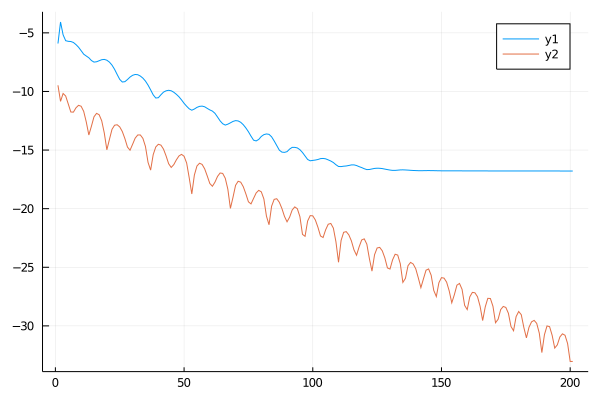

In [37]:
plot(log.(his))
plot!(log.(his2))

### solution

In [38]:
function ube_rhs(f, p, t)
    M = p[1:nu]
    τ = p[nu+1]
    p_nn = p[nu+2:end]

    (M .- f) ./ τ .+ model_univ(M .- f, p_nn)
end

ube_rhs (generic function with 1 method)

In [39]:
ube = ODEProblem(ube_rhs, f0_1D, tspan, [M0_1D; τ0; res.minimizer]);
sol = solve(ube, Midpoint(), u0=f0_1D, p=[M0_1D; τ0; res.minimizer], saveat=tran);
sol2 = solve(ube, Midpoint(), u0=f0_1D, p=[M0_1D; τ0; res2.minimizer], saveat=tran);

In [125]:
ube = ODEProblem(ube_rhs, f1_1D, tspan, [M1_1D; τ1; res.minimizer]);
sol = solve(ube, Midpoint(), u0=f1_1D, p=[M1_1D; τ1; res.minimizer], saveat=tran);
sol2 = solve(ube, Midpoint(), u0=f1_1D, p=[M1_1D; τ1; res2.minimizer], saveat=tran);

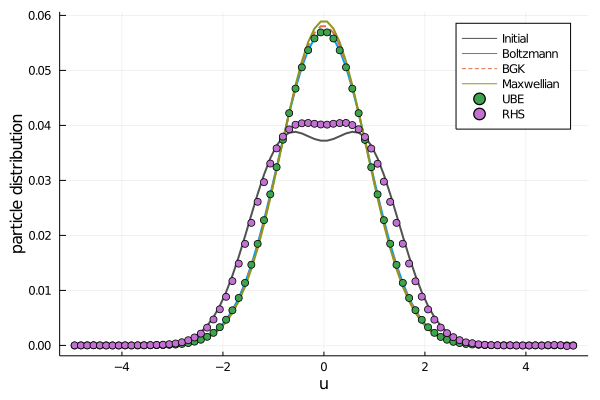

In [40]:
t1=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], dbz0_1D[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
t1=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], dbz0_1D[:,end], lw=2, label="Boltzmann", color=1)
t1=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], dbgk0_1D[:,end], lw=2, line=:dash, label="BGK", color=2)
t1=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
t1=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol.u[end], lw=2, label="UBE", color=3)
t1=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol2.u[2], lw=2, label="RHS", color=4)

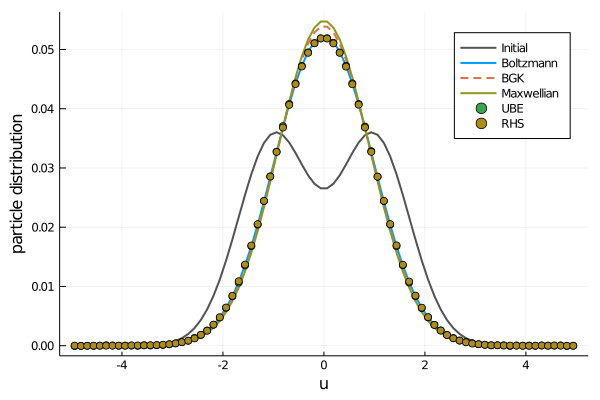

In [104]:
t4=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
t4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,end], lw=2, label="Boltzmann", color=1)
t4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_bgk_1D[:,end], lw=2, line=:dash, label="BGK", color=2)
t4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
t4=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol.u[end], lw=2, label="UBE", color=3)
t4=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol2.u[end], lw=2, label="RHS", color=5)

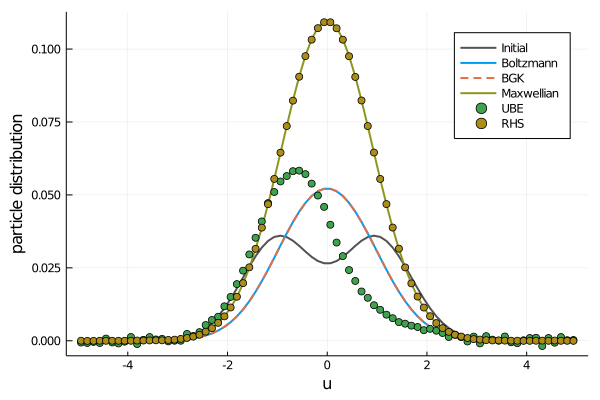

In [129]:
t4=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], dbz2_1D[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
t4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], dbz2_1D[:,end], lw=2, label="Boltzmann", color=1)
t4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], dbz2_1D[:,end], lw=2, line=:dash, label="BGK", color=2)
t4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M1_1D, lw=2, label="Maxwellian", color=10)
t4=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol.u[end], lw=2, label="UBE", color=3)
t4=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol2.u[end], lw=2, label="RHS", color=5)

### entropy

In [41]:
v1d = VSpace1D(u0, u1, nu, vMeshType);

etrp = zeros(8)
for i in eachindex(etrp)
    etrp[i] = sum(v1d.weights .* (sol.u[i] .* log.(abs.(sol.u[i]))))
end

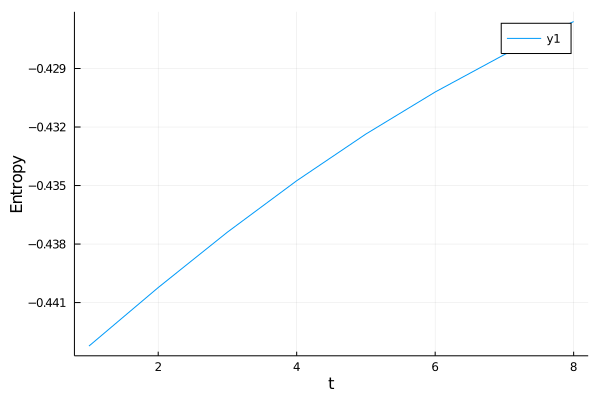

In [42]:
plot(etrp, xlabel="t", ylabel="Entropy")

In [43]:
etrp_bz = zeros(8)
for i in eachindex(etrp_bz)
    etrp_bz[i] = sum(v1d.weights .* (dbz0_1D[:,i] .* log.(abs.(dbz0_1D[:,i]))))
end

etrp_bgk = zeros(8)
for i in eachindex(etrp_bgk)
    etrp_bgk[i] = sum(v1d.weights .* (dbgk0_1D[:,i] .* log.(abs.(dbgk0_1D[:,i]))))
end

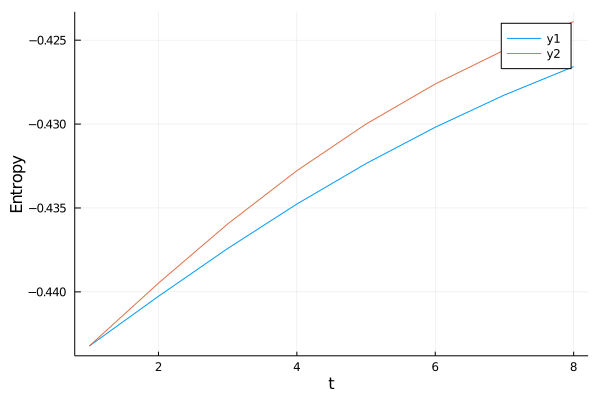

In [44]:
plot(etrp_bz, xlabel="t", ylabel="Entropy")
plot!(etrp_bgk)

In [83]:
etrp_bz = zeros(8)
for i in eachindex(etrp_bz)
    etrp_bz[i] = sum(-vSpace.weights .* (dbz0[:,:,:,i] .* log.(abs.(dbz0[:,:,:,i]))))
end

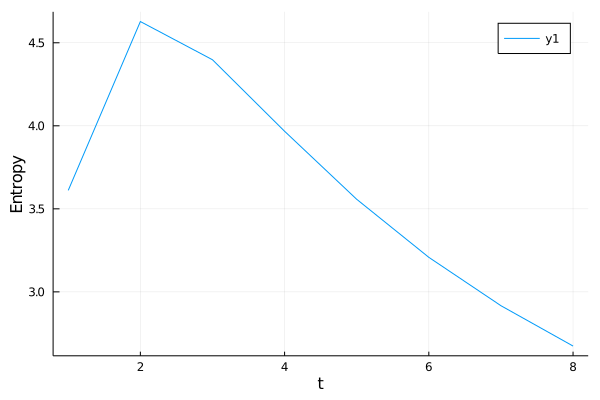

In [84]:
plot(etrp_bz, xlabel="t", ylabel="Entropy")

In [81]:
etrp_bgk = zeros(8)
for i in eachindex(etrp_bgk)
    etrp_bgk[i] = sum(-vSpace.weights .* (dbgk0[:,:,:,i] .* log.(abs.(dbgk0[:,:,:,i]))))
end

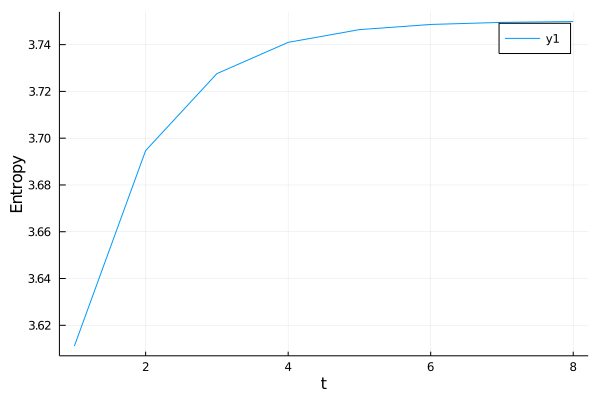

In [82]:
plot(etrp_bgk, xlabel="t", ylabel="Entropy")

In [85]:
etrp_bz

8-element Array{Float64,1}:
 3.611122197685396
 4.627880925746375
 4.397738930185844
 3.9671117289957394
 3.557391075352076
 3.2079083610174832
 2.916625419634795
 2.673628250407826

In [86]:
etrp_bgk

8-element Array{Float64,1}:
 3.611122197685396
 3.694693539512121
 3.727613633216711
 3.7409835092638795
 3.7464234879324505
 3.748625812823281
 3.7495134311404144
 3.74986898066515